In [3]:
import h2o
import csv
import time
import psutil
import logging
import optparse
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, sys
import simplejson as json
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from h2o.automl import H2OAutoML
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from distutils.util import strtobool
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
sns.set(context="notebook", palette="Spectral", style="darkgrid", font_scale=1.5, color_codes=True)
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("survey_results_public.csv")

In [5]:
min_mem_size=6
run_time=222

In [6]:
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

0


In [7]:
port_no = random.randint(5555, 55555)

try:
    h2o.init(strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no)
except:
    logging.critical('h2o.init')
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:12581..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.23+7-LTS-222, mixed mode)
  Starting server from C:\Users\nasik\anaconda3\envs\dsproj\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\nasik\AppData\Local\Temp\tmplh64z6bm
  JVM stdout: C:\Users\nasik\AppData\Local\Temp\tmplh64z6bm\h2o_nasik_started_from_python.out
  JVM stderr: C:\Users\nasik\AppData\Local\Temp\tmplh64z6bm\h2o_nasik_started_from_python.err
  Server is running at http://127.0.0.1:12581
Connecting to H2O server at http://127.0.0.1:12581 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,4 months and 24 days
H2O_cluster_name:,H2O_from_python_nasik_b0k52n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.943 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [8]:
df.head()

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [9]:
df = df[["Country", "EdLevel", "YearsCodePro", "Employment", "ConvertedComp"]]
df = df.rename({"ConvertedComp" : "Salary"}, axis = 1)
df.head()

,Country,EdLevel,YearsCodePro,Employment,Salary
0,Germany,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",27,"Independent contractor, freelancer, or self-em...",NaN
1,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,Employed full-time,NaN
2,Russian Federation,NaN,NaN,NaN,NaN
3,Albania,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,NaN,NaN
4,United States,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,Employed full-time,NaN


In [10]:
df = df[df["Salary"].notnull()]
df.head()

,Country,EdLevel,YearsCodePro,Employment,Salary
7,United States,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",13,Employed full-time,116000.0
9,United Kingdom,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",4,Employed full-time,32315.0
10,United Kingdom,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,Employed full-time,40070.0
11,Spain,Some college/university study without earning ...,7,Employed full-time,14268.0
12,Netherlands,"Secondary school (e.g. American high school, G...",20,Employed full-time,38916.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34756 entries, 7 to 64154
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       34756 non-null  object 
 1   EdLevel       34188 non-null  object 
 2   YearsCodePro  34621 non-null  object 
 3   Employment    34717 non-null  object 
 4   Salary        34756 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.6+ MB


In [12]:
df = df.dropna()
df.isnull().sum()

Country         0
EdLevel         0
YearsCodePro    0
Employment      0
Salary          0
dtype: int64

In [13]:
df = df[df["Employment"] == "Employed full-time"]
df = df.drop("Employment", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30019 entries, 7 to 64154
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       30019 non-null  object 
 1   EdLevel       30019 non-null  object 
 2   YearsCodePro  30019 non-null  object 
 3   Salary        30019 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


In [14]:
df["Country"].value_counts()

Country
United States     7569
India             2425
United Kingdom    2287
Germany           1903
Canada            1178
                  ... 
Benin                1
Fiji                 1
San Marino           1
Guinea               1
Andorra              1
Name: count, Length: 154, dtype: int64

In [15]:
def shorten_categories(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = "Other"
    return categorical_map

In [16]:
country_map = shorten_categories(df.Country.value_counts(), 400)
df['Country'] = df['Country'].map(country_map)
df.Country.value_counts()

Country
Other                 8549
United States         7569
India                 2425
United Kingdom        2287
Germany               1903
Canada                1178
Brazil                 991
France                 972
Spain                  670
Australia              659
Netherlands            654
Poland                 566
Italy                  560
Russian Federation     522
Sweden                 514
Name: count, dtype: int64

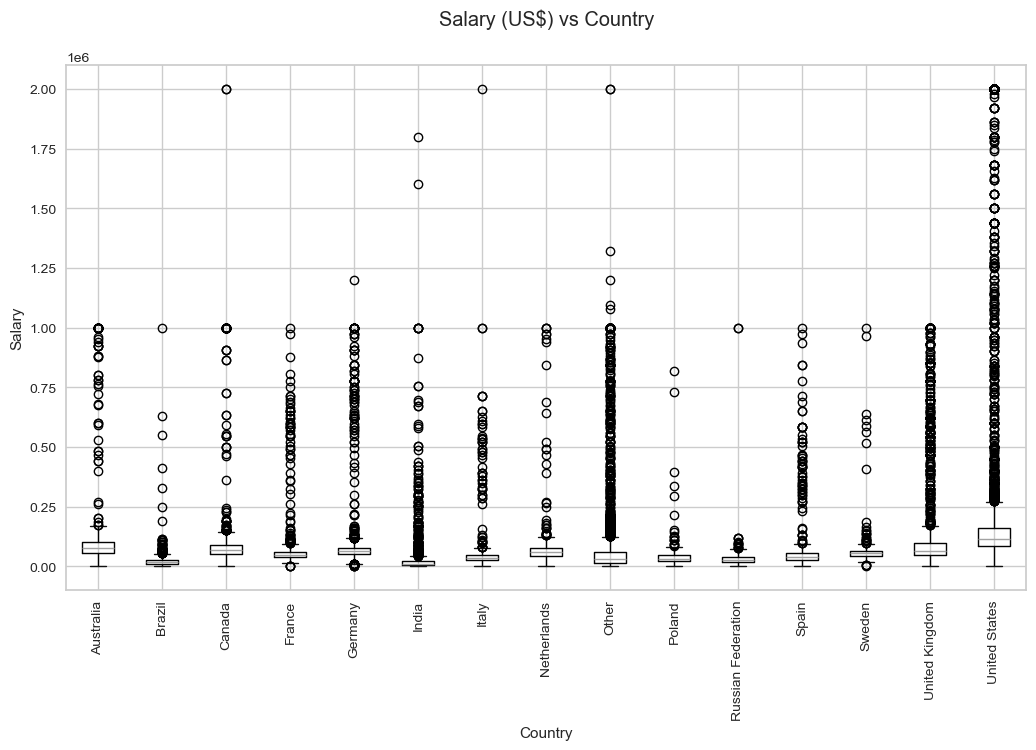

In [17]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
df.boxplot('Salary', 'Country', ax=ax)
plt.suptitle('Salary (US$) vs Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation = 90)
plt.show()

In [18]:
df = df[df["Salary"] <= 250000]
df = df[df["Salary"] >= 10000]
df = df[df["Country"] != "Other"]

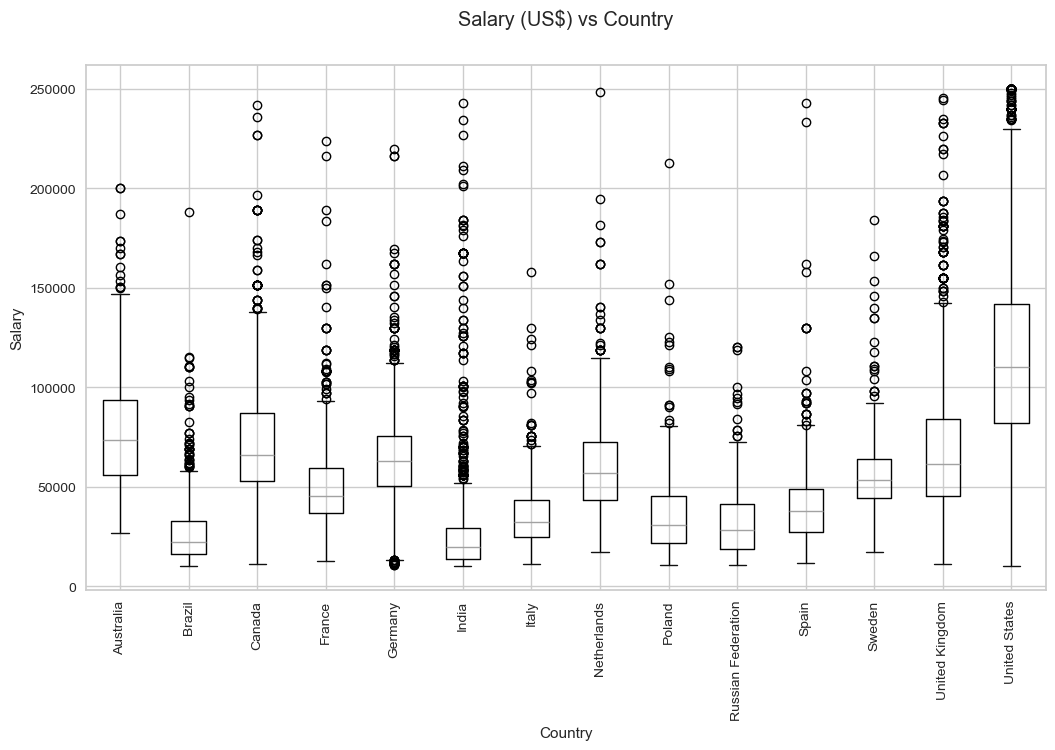

In [19]:
fig, ax = plt.subplots(1,1, figsize=(12,7))
df.boxplot('Salary', 'Country', ax =ax)
plt.suptitle('Salary (US$) vs Country')
plt.title('')
plt.ylabel('Salary')
plt.xticks(rotation = 90)
plt.show()

In [20]:
df["YearsCodePro"].unique()

array(['13', '4', '2', '7', '20', '1', '3', '10', '12', '29', '6', '28',
       '8', '23', '15', '25', '9', '11', 'Less than 1 year', '5', '21',
       '16', '18', '14', '32', '19', '22', '38', '30', '26', '27', '17',
       '24', '34', '35', '33', '36', '40', '39', 'More than 50 years',
       '31', '37', '41', '45', '42', '44', '43', '50', '49'], dtype=object)

In [21]:
def clean_experience(x):
    if x == "More than 50 years":
        return 50
    if x == "Less than 1 year":
        return 0.5
    return float(x)

df["YearsCodePro"] = df["YearsCodePro"].apply(clean_experience)

In [22]:
df["EdLevel"].unique()

array(['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Some college/university study without earning a degree',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Associate degree (A.A., A.S., etc.)',
       'Professional degree (JD, MD, etc.)',
       'Other doctoral degree (Ph.D., Ed.D., etc.)',
       'I never completed any formal education',
       'Primary/elementary school'], dtype=object)

In [23]:
def clean_education(x):
    if 'Bachelor’s degree' in x:
        return 'Bachelor’s degree'
    if 'Master’s degree' in x:
        return 'Master’s degree'
    if 'Professional degree' in x or 'Other doctoral' in x:
        return 'Post grad'
    return 'Less than a Bachelors'

df['EdLevel'] = df['EdLevel'].apply(clean_education)

In [24]:
df["EdLevel"].unique()

array(['Bachelor’s degree', 'Master’s degree', 'Less than a Bachelors',
       'Post grad'], dtype=object)

In [25]:
from sklearn.preprocessing import LabelEncoder
le_education = LabelEncoder()
df['EdLevel'] = le_education.fit_transform(df['EdLevel'])
df["EdLevel"].unique()
#le.classes_

array([0, 2, 1, 3])

In [26]:
le_country = LabelEncoder()
df['Country'] = le_country.fit_transform(df['Country'])
df["Country"].unique()

array([13, 12, 10,  7,  4,  2,  6,  1,  3,  5, 11,  8,  0,  9])

In [27]:
X = df.drop("Salary", axis=1)
y = df["Salary"]

In [28]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
linear_reg.fit(X, y.values)

LinearRegression()

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred_linear = linear_reg.predict(X)

mae_linear = mean_absolute_error(y, y_pred_linear)
mse_linear = mean_squared_error(y, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y, y_pred_linear)

print(f"Mean Absolute Error of Linear Regression Model (MAE): {mae_linear}")
print(f"Mean Square Error of Linear Regression Model (MSE): {mse_linear}")
print(f"Root Mean Square Error of Linear Regression Model (RMSE): {rmse_linear}")
print(f"R-squared of Linear Regression Model (R2): {r2_linear}")

Mean Absolute Error of Linear Regression Model (MAE): 30479.812570833863
Mean Square Error of Linear Regression Model (MSE): 1542506276.8748605
Root Mean Square Error of Linear Regression Model (RMSE): 39274.75368318509
R-squared of Linear Regression Model (R2): 0.32368918978926564


In [30]:
from sklearn.tree import DecisionTreeRegressor
dec_tree_reg = DecisionTreeRegressor(random_state=0)
dec_tree_reg.fit(X, y.values)

DecisionTreeRegressor(random_state=0)

In [31]:
y_pred_decision_tree = dec_tree_reg.predict(X)

mae_decision_tree = mean_absolute_error(y, y_pred_decision_tree)
mse_decision_tree = mean_squared_error(y, y_pred_decision_tree)
rmse_decision_tree = np.sqrt(mse_decision_tree)
r2_decision_tree = r2_score(y, y_pred_decision_tree)

print(f"Mean Absolute Error of Linear Regression Model (MAE): {mae_decision_tree}")
print(f"Mean Square Error of Linear Regression Model (MSE): {mse_decision_tree}")
print(f"Root Mean Square Error of Linear Regression Model (RMSE): {rmse_decision_tree}")
print(f"R-squared of Linear Regression Model (R2): {r2_decision_tree}")

Mean Absolute Error of Linear Regression Model (MAE): 19972.53583592743
Mean Square Error of Linear Regression Model (MSE): 865238589.711687
Root Mean Square Error of Linear Regression Model (RMSE): 29414.938206831015
R-squared of Linear Regression Model (R2): 0.6206367387891172


In [32]:
from sklearn.ensemble import RandomForestRegressor
random_forest_reg = RandomForestRegressor(random_state=0)
random_forest_reg.fit(X, y.values)

RandomForestRegressor(random_state=0)

In [33]:
y_pred_random_forest = random_forest_reg.predict(X)

mae_random_forest = mean_absolute_error(y, y_pred_random_forest)
mse_random_forest = mean_squared_error(y, y_pred_random_forest)
rmse_random_forest = np.sqrt(mse_random_forest)
r2_random_forest = r2_score(y, y_pred_random_forest)

print(f"Mean Absolute Error of Random Forest Model (MAE): {mae_random_forest}")
print(f"Mean Square Error of Random Forest Model (MSE): {mse_random_forest}")
print(f"Root Mean Square Error of Random Forest Model (RMSE): {rmse_random_forest}")
print(f"R-squared of Random Forest Model (R2): {r2_random_forest}")

Mean Absolute Error of Random Forest Model (MAE): 20166.160479812872
Mean Square Error of Random Forest Model (MSE): 869501373.5644206
Root Mean Square Error of Random Forest Model (RMSE): 29487.30868635557
R-squared of Random Forest Model (R2): 0.6187677241572698


In [34]:
h2o_df = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [35]:
h2o_df.head()

Country,EdLevel,YearsCodePro,Salary
13,0,13,116000
12,2,4,32315
12,0,2,40070
10,1,7,14268
7,1,20,38916
13,1,1,66000
13,0,3,79000
13,0,3,83400
4,3,20,91883
2,0,10,71093


In [36]:
pct_rows = 0.80
df_train, df_test = h2o_df.split_frame([pct_rows])

In [37]:
h2o_X=h2o_df.columns
h2o_y_numeric = 'Salary'
h2o_X.remove(h2o_y_numeric)

In [38]:
# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

In [39]:
# Pass the data through H2oAutoML
aml.train(x=h2o_X, y=h2o_y_numeric, training_frame=df_train)

AutoML progress: |
22:17:20.165: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),10/49
# GBM base models (used / total),9/41
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),1/5
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [40]:
print(aml.leaderboard)

model_id                                                    rmse          mse      mae     rmsle    mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_1_20240806_221720     30648.4  9.39326e+08  21161.5  0.39658                9.39326e+08
StackedEnsemble_BestOfFamily_4_AutoML_1_20240806_221720  30666.4  9.40427e+08  21197.5  0.397399               9.40427e+08
GBM_grid_1_AutoML_1_20240806_221720_model_36             30675.9  9.41009e+08  21250.4  0.399858               9.41009e+08
StackedEnsemble_AllModels_2_AutoML_1_20240806_221720     30716.7  9.43515e+08  21250.7  0.399896               9.43515e+08
StackedEnsemble_AllModels_1_AutoML_1_20240806_221720     30717.2  9.43544e+08  21248.7  0.399794               9.43544e+08
GBM_grid_1_AutoML_1_20240806_221720_model_2              30718.1  9.43604e+08  21268.4  0.401515               9.43604e+08
GBM_grid_1_AutoML_1_20240806_221720_model_27             30743.2  9.45142e+08  21349.6  0.404917               9.45142e+08
StackedEnsemble_

In [41]:
best_model = aml.get_best_model()
print(best_model)

Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20240806_221720


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       10/49
# GBM base models (used / total)           9/41
# DRF base models (used / total)           0/2
# DeepLearning base models (used / total)  1/5
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 925957443.9726713
RMSE: 30429.548862457217
MAE: 20959.59505066465
RMSLE: 0.3896792458547357
Mean Residual Deviance: 925957443.9726713
R

In [42]:
from sklearn.model_selection import GridSearchCV

max_depth = [None, 2,4,6,8,10,12]
parameters = {"max_depth": max_depth}

regressor = DecisionTreeRegressor(random_state=0)
gs = GridSearchCV(regressor, parameters, scoring='neg_mean_squared_error')
gs.fit(X, y.values)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10, 12]},
             scoring='neg_mean_squared_error')

In [43]:
regressor = gs.best_estimator_

regressor.fit(X, y.values)
y_pred = regressor.predict(X)
error = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)
print("${:,.02f}".format(error))
print(f"R-squared (R2): {r2}")

$30,428.51
R-squared (R2): 0.5940423629626365


In [44]:
X

,Country,EdLevel,YearsCodePro
7,13,0,13.0
9,12,2,4.0
10,12,0,2.0
11,10,1,7.0
12,7,1,20.0
...,...,...,...
64113,13,1,15.0
64116,13,0,6.0
64122,13,1,4.0
64127,13,3,12.0


In [45]:
# country, edlevel, yearscode
X = np.array([["United States", 'Master’s degree', 15 ]])
X

array([['United States', 'Master’s degree', '15']], dtype='<U15')

In [46]:
X[:, 0] = le_country.transform(X[:,0])
X[:, 1] = le_education.transform(X[:,1])
X = X.astype(float)
X

array([[13.,  2., 15.]])

In [47]:
y_pred = regressor.predict(X)
y_pred

array([139427.26315789])

In [48]:
y_pred_linear = linear_reg.predict(X)
y_pred_decision_tree = dec_tree_reg.predict(X)
y_pred_random_forest = random_forest_reg.predict(X)

print(y_pred_linear)
print(y_pred_decision_tree)
print(y_pred_random_forest)

[108641.10866558]
[146432.08510638]
[146033.12406196]


In [49]:
import pickle

In [50]:
data = {"best_model": regressor, "linear_model": linear_reg, "decision_tree_model": dec_tree_reg, "random_forest_model": random_forest_reg, "le_country": le_country, "le_education": le_education}
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(data, file)

In [51]:
with open('saved_steps.pkl', 'rb') as file:
    data = pickle.load(file)

best_model_regressor = data["best_model"]
linear_model_regressor = data["linear_model"]
decision_tree_regressor = data["decision_tree_model"]
random_forest_regressor = data["random_forest_model"]
le_country = data["le_country"]
le_education = data["le_education"]

In [52]:
y_pred = best_model_regressor.predict(X)
y_pred_l = linear_model_regressor.predict(X)
y_pred_d = decision_tree_regressor.predict(X)
y_pred_r = random_forest_regressor.predict(X)

print(y_pred)
print(y_pred_l)
print(y_pred_d)
print(y_pred_r)

[139427.26315789]
[108641.10866558]
[146432.08510638]
[146033.12406196]
